In [126]:
# import all libraries numpy, pandas, matplotlib, seaborn. 

import numpy as np, pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(color_codes=True)

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
%matplotlib inline

# Set custom display properties in pandas
pd.set_option("display.max_rows", 900)
pd.set_option("display.max_columns", 900) 
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [127]:
# To distinguish numerical columns either as categorical/discrete or non categorical and return as dict
def classify_feature_dtype(df,cols):
    d_categories = {'int_cat': [], "float_ts":[] }
    for col in cols:
        if (len(df[col].unique()) < 20):
            d_categories['int_cat'].append(col)
        else:
            d_categories['float_ts'].append(col)
    return d_categories

# Print all statistical information for a given set of columns
def show_stats(df, cols):
    for col in list(cols):
        print("Total Nulls: {0},\nMode: {1}".format(df[col].isna().sum(), df[col].mode()[0]))
        if len(df[col].unique()) < 50:
            print("\nUnique: {0}\n".format(df[col].unique()))
        if (df[col].dtype == int) or (df[col].dtype == float):
            print("Median   : {0}, \nVariance: {1}, \n\nDescribe: {2} \n".format(df[col].median(), df[col].var(), df[col].describe()))
        print("ValueCounts: {0} \n\n\n".format((df[col].value_counts(normalize=True) * 100).head(5)))
        print("------------------------------------------------------------------")

# Return the percentage of null values in each columns in a dataframe
def check_cols_null_pct(df):
    df_non_na = df.count() / len(df)  # Ratio of non null values
    df_na_pct = (1 - df_non_na) * 100 # Find the Percentage of null values
    return df_na_pct.sort_values(ascending=False) # Sort the resulting values in descending order

# Generates charts based on the data type of the cols, as part of the univariate analysis 
# it takes dataframe, columns, train data 0,1, and feature type as args.
def univariate_plots(df, cols, target=None, ftype=None, l_dict = None):
    for col in cols:
        #generate plots and graphs for category type. (generates piechart, countplot, boxplot / if training data is provided it generates bar chart instead)
        if ftype == "categorical":
            fig, axs = plt.subplots(1, 3, figsize=(20, 6))
                        
            col_idx = 0
            axs[col_idx].pie(x=df[col].value_counts().head(15), labels=df[col].value_counts().head(15).index.str[:15], autopct="%1.1f%%", 
                    radius=1, textprops={"fontsize": 10, "color": "Black"}, startangle=90, rotatelabels=False)
            axs[col_idx].set_title("PieChart of {0}".format(col), y=1); plt.xticks(rotation=45); plt.ylabel("Percentage")
            fig.subplots_adjust(wspace=0.5, hspace=0.3)
            
            col_idx += 1
            sns.countplot(data=df, y=col, order=df[col].value_counts().index, palette="viridis",  ax=axs[col_idx])
            if (l_dict is not None) and (l_dict.get(col) is not None):
                axs[col_idx].legend([ f'{k} - {v}' for k,v in l_dict[col].items()])
            axs[col_idx].set_title("Countplot of {0}".format(col)); plt.xticks(rotation=45); plt.xlabel(col); plt.ylabel("Count")
            fig.subplots_adjust(wspace=0.5, hspace=0.3)

            col_idx += 1
            ax = sns.barplot(data=df, x=df[col].str[:15], y=target, palette="viridis",  ax=axs[col_idx], errwidth=0)
            for i in ax.containers:
                ax.bar_label(i,)
            axs[col_idx].set_title('Barplot against target'); plt.xticks(rotation=45); plt.xlabel(col)
            fig.subplots_adjust(wspace=0.5, hspace=0.3)

            plt.suptitle("Univariate analysis of {0}".format(col), fontsize=12, y=0.95)
            plt.tight_layout()
            plt.subplots_adjust(top=0.85)
            plt.show()
            plt.clf()

        #generate plots and graphs for numerical types. (generates boxplot, histplot, kdeplot, scatterplot)
        elif ftype == "non_categorical":        
            fig, axs = plt.subplots(1, 4, figsize=(20, 6))
            
            col_idx = 0
            
            sns.boxplot(data=df, y=col, palette="viridis", flierprops=dict( marker="o", markersize=6, markerfacecolor="red", markeredgecolor="black"),
                        medianprops=dict(linestyle="-", linewidth=3, color="#FF9900"), whiskerprops=dict(linestyle="-", linewidth=2, color="black"),
                        capprops=dict(linestyle="-", linewidth=2, color="black"), ax=axs[col_idx])
            axs[col_idx].set_title("Boxplot of {0}".format(col)); plt.xticks(rotation=45); plt.xlabel(col)
            fig.subplots_adjust(wspace=0.5, hspace=0.3)
            
            col_idx += 1

            axs[col_idx].hist(data=df, x=col, label=col)
            axs[col_idx].set_title("Histogram of {0}".format(col)); plt.xticks(rotation=45); plt.xlabel(col)
            fig.subplots_adjust(wspace=0.5, hspace=0.3)
            
            col_idx += 1

            sns.kdeplot(df[col], shade=True, ax=axs[col_idx])
            axs[col_idx].set_title("KDE plot of {0}".format(col)); plt.xticks(rotation=45); plt.xlabel(col)
            fig.subplots_adjust(wspace=0.5, hspace=0.3)
            
            col_idx += 1

            sns.scatterplot(df[col], ax=axs[col_idx])
            axs[col_idx].set_title("Scatterplot of {0}".format(col)); plt.xticks(rotation=45); plt.xlabel(col)
            fig.subplots_adjust(wspace=0.5, hspace=0.3)

            plt.suptitle("Univariate analysis of {0}".format(col), fontsize=12, y=0.95)
            plt.tight_layout()
            plt.subplots_adjust(top=0.85)
            plt.show()
            plt.clf()
    
# Perform Outlier analysis on the given dataframe.
# Find Lower threshold, Upper threshold and IQR values. 
# Return the Result as a dataframe. 
# find_outlier = True argument: restricts the output df to outlier columns. whereas find_outlier = False: returns results for all columns
def get_extremeval_threshld(df, find_outlier=False):
    outlier_df = pd.DataFrame(columns=[i for i in df.columns if find_outlier == True], data=None)
    
    for col in df.columns:
        thirdq, firstq = df[col].quantile(0.75), df[col].quantile(0.25)
        iqr = 1.5 * (thirdq - firstq)
        extvalhigh, extvallow = iqr + thirdq, firstq - iqr
        
        if find_outlier == True:
            dfout = df.loc[(df[col] > extvalhigh) | (df[col] < extvallow)]
            dfout = dfout.assign(name=col, thresh_low=extvallow, thresh_high=extvalhigh)
        else:
            dfout = pd.DataFrame([[col, extvallow, extvalhigh]], columns=['name', 'thresh_low', 'thresh_high'])
            
        outlier_df = pd.concat([outlier_df, dfout])
    # outlier_df = outlier_df.reset_index(drop=True)
    outlier_df = outlier_df.set_index('name',drop=True)
    return outlier_df

In [128]:
df = pd.read_csv('Leads.csv')
df.head(1)

Prospect ID  Lead Number Lead Origin Lead Source  \
0  7927b2df-8bba-4d29-b9a2-b6e0beafe620       660737         API  Olark Chat   

  Do Not Email Do Not Call  Converted  TotalVisits  \
0           No          No          0        0.000   

   Total Time Spent on Website  Page Views Per Visit            Last Activity  \
0                            0                 0.000  Page Visited on Website   

  Country Specialization How did you hear about X Education  \
0     NaN         Select                             Select   

  What is your current occupation  \
0                      Unemployed   

  What matters most to you in choosing a course Search Magazine  \
0                       Better Career Prospects     No       No   

  Newspaper Article X Education Forums Newspaper Digital Advertisement  \
0                No                 No        No                    No   

  Through Recommendations Receive More Updates About Our Courses  \
0                      No                                     No   

                          Tags      Lead Quality  \
0  Interested in other courses  Low in Relevance   

  Update me on Supply Chain Content Get updates on DM Content Lead Profile  \
0                                No                        No       Select   

     City Asymmetrique Activity Index Asymmetrique Profile Index  \
0  Select                   02.Medium                  02.Medium   

   Asymmetrique Activity Score  Asymmetrique Profile Score  \
0                       15.000                      15.000   

  I agree to pay the amount through cheque  \
0                                       No   

  A free copy of Mastering The Interview Last Notable Activity  
0                                     No              Modified

In [129]:
#convert dtypes 
obj_cols = df.select_dtypes(include=object).columns
df[obj_cols] = df[obj_cols].astype(dtype='category')

In [130]:
#duplicates row validation by id cols
print(f"{df.index.is_unique}, {df.columns.is_unique}, {df['Prospect ID'].is_unique}, {df['Lead Number'].is_unique}")

True, True, True, True


In [131]:
#drop unecessary columns
df = df.drop(columns=['Prospect ID', 'I agree to pay the amount through cheque', 'Last Notable Activity'])

In [132]:
#rename columns that are too long
df = df.rename(columns={'Total Time Spent on Website':'ttime_on_site', 'Page Views Per Visit':'pg_view_pv', 'How did you hear about X Education':'info_abt_X_Edu', 'What is your current occupation':'curr_occupation',
    'What matters most to you in choosing a course':'reason_behind_course', 'Receive More Updates About Our Courses':'more_course_updates', 'Update me on Supply Chain Content':'supply_chain_info', 'Get updates on DM Content':'get_dm',
    'Asymmetrique Activity Index':'asym_activ_idx', 'Asymmetrique Profile Index':'asym_prof_idx', 'Asymmetrique Activity Score':'asym_activ_score', 'Asymmetrique Profile Score':'asym_prof_score',
    'A free copy of Mastering The Interview':'avail_free_copy'})

In [133]:
# replace unnecessary space in columns with underscore and covert it to lower case
df.columns = df.columns.str.replace(pat=' ',repl='_',regex=True)
df.columns = df.columns.str.lower()

In [134]:
df.head(1)
print(f'{df.shape},{df.size}')
df.dtypes

lead_number lead_origin lead_source do_not_email do_not_call  converted  \
0       660737         API  Olark Chat           No          No          0   

   totalvisits  ttime_on_site  pg_view_pv            last_activity country  \
0        0.000              0       0.000  Page Visited on Website     NaN   

  specialization info_abt_x_edu curr_occupation     reason_behind_course  \
0         Select         Select      Unemployed  Better Career Prospects   

  search magazine newspaper_article x_education_forums newspaper  \
0     No       No                No                 No        No   

  digital_advertisement through_recommendations more_course_updates  \
0                    No                      No                  No   

                          tags      lead_quality supply_chain_info get_dm  \
0  Interested in other courses  Low in Relevance                No     No   

  lead_profile    city asym_activ_idx asym_prof_idx  asym_activ_score  \
0       Select  Select      02.Medium     02.Medium            15.000   

   asym_prof_score avail_free_copy  
0           15.000              No

(9240, 34),314160


lead_number                   int64
lead_origin                category
lead_source                category
do_not_email               category
do_not_call                category
converted                     int64
totalvisits                 float64
ttime_on_site                 int64
pg_view_pv                  float64
last_activity              category
country                    category
specialization             category
info_abt_x_edu             category
curr_occupation            category
reason_behind_course       category
search                     category
magazine                   category
newspaper_article          category
x_education_forums         category
newspaper                  category
digital_advertisement      category
through_recommendations    category
more_course_updates        category
tags                       category
lead_quality               category
supply_chain_info          category
get_dm                     category
lead_profile               c

In [135]:
#check null val percentage
100*df.isna().sum()/len(df)

lead_number                0.000
lead_origin                0.000
lead_source                0.390
do_not_email               0.000
do_not_call                0.000
converted                  0.000
totalvisits                1.483
ttime_on_site              0.000
pg_view_pv                 1.483
last_activity              1.115
country                   26.634
specialization            15.563
info_abt_x_edu            23.885
curr_occupation           29.113
reason_behind_course      29.318
search                     0.000
magazine                   0.000
newspaper_article          0.000
x_education_forums         0.000
newspaper                  0.000
digital_advertisement      0.000
through_recommendations    0.000
more_course_updates        0.000
tags                      36.288
lead_quality              51.591
supply_chain_info          0.000
get_dm                     0.000
lead_profile              29.318
city                      15.368
asym_activ_idx            45.649
asym_prof_

In [136]:
#replace select string with nan
df = df.replace(to_replace='select|Select',value=np.nan,regex=True)
# validate select str is replaced
[i for i in df.columns if 'select' in (df[i].astype(str).str.lower()).str.findall('select').value_counts().index.map(''.join).to_list()]


[]

In [137]:
from fast_ml.utilities import display_all
from fast_ml.feature_selection import get_constant_features

constant_features = get_constant_features(df)
constant_features.head(10)
"','".join(constant_features['Var'].to_list())

Desc                      Var Value    Perc
0        Constant                 magazine    No 100.000
1        Constant      more_course_updates    No 100.000
2        Constant        supply_chain_info    No 100.000
3        Constant                   get_dm    No 100.000
4  Quasi Constant       x_education_forums    No  99.989
5  Quasi Constant                newspaper    No  99.989
6  Quasi Constant              do_not_call    No  99.978
7  Quasi Constant        newspaper_article    No  99.978
8  Quasi Constant    digital_advertisement    No  99.957
9  Quasi Constant  through_recommendations    No  99.924

"magazine','more_course_updates','supply_chain_info','get_dm','x_education_forums','newspaper','do_not_call','newspaper_article','digital_advertisement','through_recommendations','search"

In [138]:
df = df.drop(['magazine','more_course_updates','supply_chain_info','get_dm','x_education_forums','newspaper','do_not_call','newspaper_article','digital_advertisement','through_recommendations','search'],axis=1)

In [139]:
#check null val percentage
null_pct = 100*df.isna().sum()/len(df)
null_pct
df = df.drop(null_pct[null_pct > 40].index, axis=1)

lead_number             0.000
lead_origin             0.000
lead_source             0.390
do_not_email            0.000
converted               0.000
totalvisits             1.483
ttime_on_site           0.000
pg_view_pv              1.483
last_activity           1.115
country                26.634
specialization         36.580
info_abt_x_edu         78.463
curr_occupation        29.113
reason_behind_course   29.318
tags                   36.288
lead_quality           51.591
lead_profile           74.188
city                   39.708
asym_activ_idx         45.649
asym_prof_idx          45.649
asym_activ_score       45.649
asym_prof_score        45.649
avail_free_copy         0.000
dtype: float64

In [140]:
null_pct = 100*df.isna().sum()/len(df)
null_pct
na_cols = null_pct[null_pct > 0].index
na_cols

lead_number             0.000
lead_origin             0.000
lead_source             0.390
do_not_email            0.000
converted               0.000
totalvisits             1.483
ttime_on_site           0.000
pg_view_pv              1.483
last_activity           1.115
country                26.634
specialization         36.580
curr_occupation        29.113
reason_behind_course   29.318
tags                   36.288
city                   39.708
avail_free_copy         0.000
dtype: float64

Index(['lead_source', 'totalvisits', 'pg_view_pv', 'last_activity', 'country',
       'specialization', 'curr_occupation', 'reason_behind_course', 'tags',
       'city'],
      dtype='object')

In [141]:
df.describe(include=np.number)
df.describe(exclude=np.number)

lead_number  converted  totalvisits  ttime_on_site  pg_view_pv
count     9240.000   9240.000     9103.000       9240.000    9103.000
mean    617188.436      0.385        3.445        487.698       2.363
std      23405.996      0.487        4.855        548.021       2.161
min     579533.000      0.000        0.000          0.000       0.000
25%     596484.500      0.000        1.000         12.000       1.000
50%     615479.000      0.000        3.000        248.000       2.000
75%     637387.250      1.000        5.000        936.000       3.000
max     660737.000      1.000      251.000       2272.000      55.000

lead_origin lead_source do_not_email last_activity  \
count                      9240        9204         9240          9137   
unique                        5          21            2            17   
top     Landing Page Submission      Google           No  Email Opened   
freq                       4886        2868         8506          3437   

       country      specialization curr_occupation     reason_behind_course  \
count     6779                5860            6550                     6531   
unique      38                  18               6                        3   
top      India  Finance Management      Unemployed  Better Career Prospects   
freq      6492                 976            5600                     6528   

                                       tags    city avail_free_copy  
count                                  5887    5571            9240  
unique                                   26       6               2  
top     Will revert after reading the email  Mumbai              No  
freq                                   2072    3222            6352

In [142]:
# impute missing categorical values using mode, if a particular value in that column has higher frequency say > 50%
for i in df.select_dtypes(include='category'):
    temp = df[i].value_counts(normalize=True, ascending=False)*100
    if temp.iloc[0] > 50:
        df[i] = df[i].fillna(temp.index[0])

In [143]:
null_pct = 100*df.isna().sum()/len(df)
null_pct
null_pct[null_pct > 0]

lead_number             0.000
lead_origin             0.000
lead_source             0.390
do_not_email            0.000
converted               0.000
totalvisits             1.483
ttime_on_site           0.000
pg_view_pv              1.483
last_activity           1.115
country                 0.000
specialization         36.580
curr_occupation         0.000
reason_behind_course    0.000
tags                   36.288
city                    0.000
avail_free_copy         0.000
dtype: float64

lead_source       0.390
totalvisits       1.483
pg_view_pv        1.483
last_activity     1.115
specialization   36.580
tags             36.288
dtype: float64

In [144]:
100*(df.isna().sum()/len(df))
dff = df[(df.notna()).all(axis=1)]
100*dff.isna().sum()

lead_number             0.000
lead_origin             0.000
lead_source             0.390
do_not_email            0.000
converted               0.000
totalvisits             1.483
ttime_on_site           0.000
pg_view_pv              1.483
last_activity           1.115
country                 0.000
specialization         36.580
curr_occupation         0.000
reason_behind_course    0.000
tags                   36.288
city                    0.000
avail_free_copy         0.000
dtype: float64

lead_number             0
lead_origin             0
lead_source             0
do_not_email            0
converted               0
totalvisits             0
ttime_on_site           0
pg_view_pv              0
last_activity           0
country                 0
specialization          0
curr_occupation         0
reason_behind_course    0
tags                    0
city                    0
avail_free_copy         0
dtype: int64

In [145]:
sorted([f'{i} - {dff[i].unique()}' for i in dff.columns])

["avail_free_copy - ['Yes', 'No']\nCategories (2, object): ['No', 'Yes']",
 "city - ['Mumbai', 'Other Metro Cities', 'Thane & Outskirts', 'Other Cities', 'Other Cities of Maharashtra', 'Tier II Cities']\nCategories (7, object): ['Mumbai', 'Other Cities', 'Other Cities of Maharashtra', 'Other Metro Cities', 'Select', 'Thane & Outskirts', 'Tier II Cities']",
 'converted - [1 0]',
 "country - ['India', 'Oman', 'United States', 'Bahrain', 'United Kingdom', ..., 'Denmark', 'Philippines', 'Vietnam', 'Indonesia', 'Bangladesh']\nLength: 30\nCategories (38, object): ['Asia/Pacific Region', 'Australia', 'Bahrain', 'Bangladesh', ..., 'United Kingdom', 'United States', 'Vietnam', 'unknown']",
 "curr_occupation - ['Student', 'Unemployed', 'Working Professional', 'Businessman', 'Other', 'Housewife']\nCategories (6, object): ['Businessman', 'Housewife', 'Other', 'Student', 'Unemployed', 'Working Professional']",
 "do_not_email - ['No', 'Yes']\nCategories (2, object): ['No', 'Yes']",
 "last_activity -

In [146]:
numeric_col = ['lead_number','converted','totalvisits','ttime_on_site','pg_view_pv']
dff[numeric_col] = dff[numeric_col].astype('float')
dff.select_dtypes(exclude=[int,float]).dtypes.head()

lead_origin      category
lead_source      category
do_not_email     category
last_activity    category
country          category
dtype: object

In [147]:
dff.shape

(4368, 16)

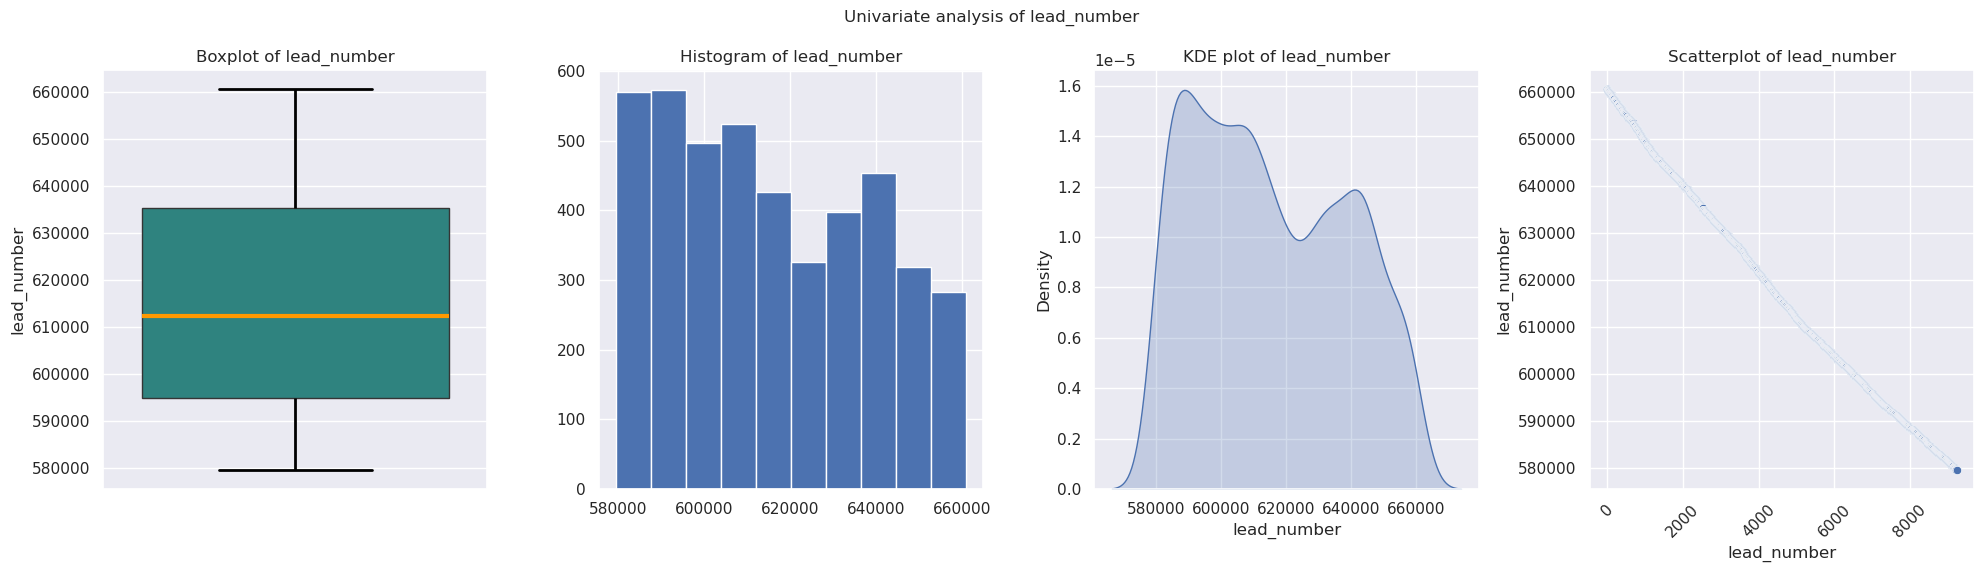

<Figure size 640x480 with 0 Axes>

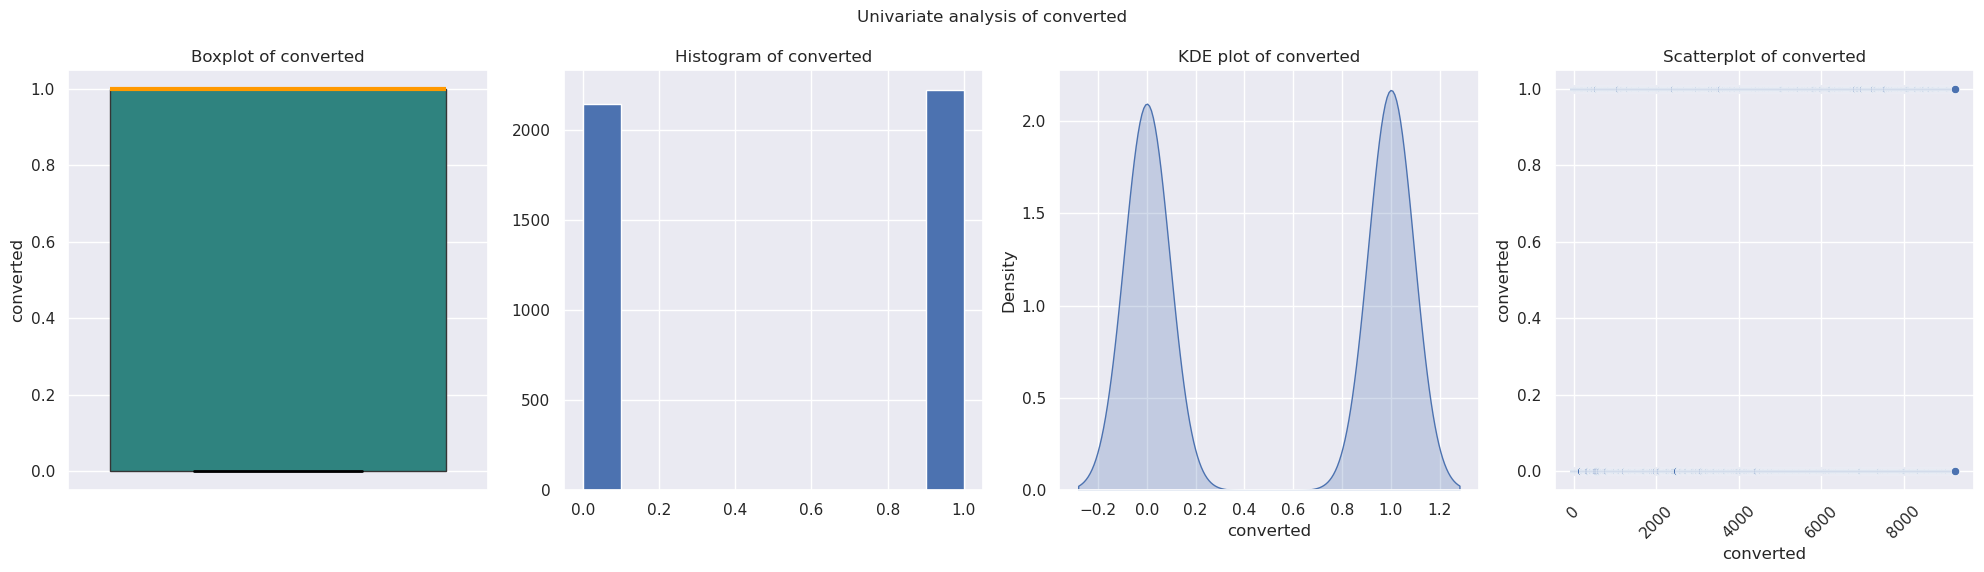

<Figure size 640x480 with 0 Axes>

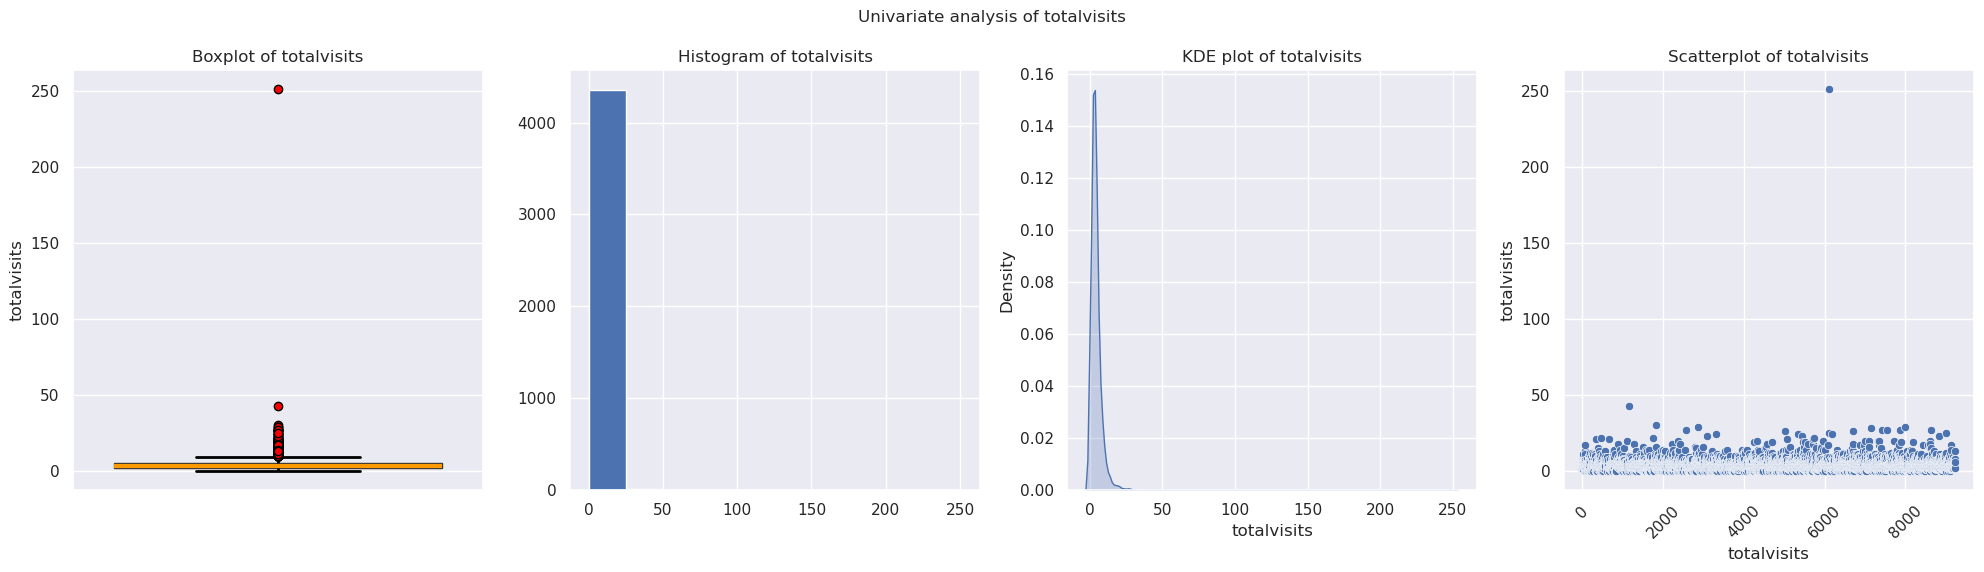

<Figure size 640x480 with 0 Axes>

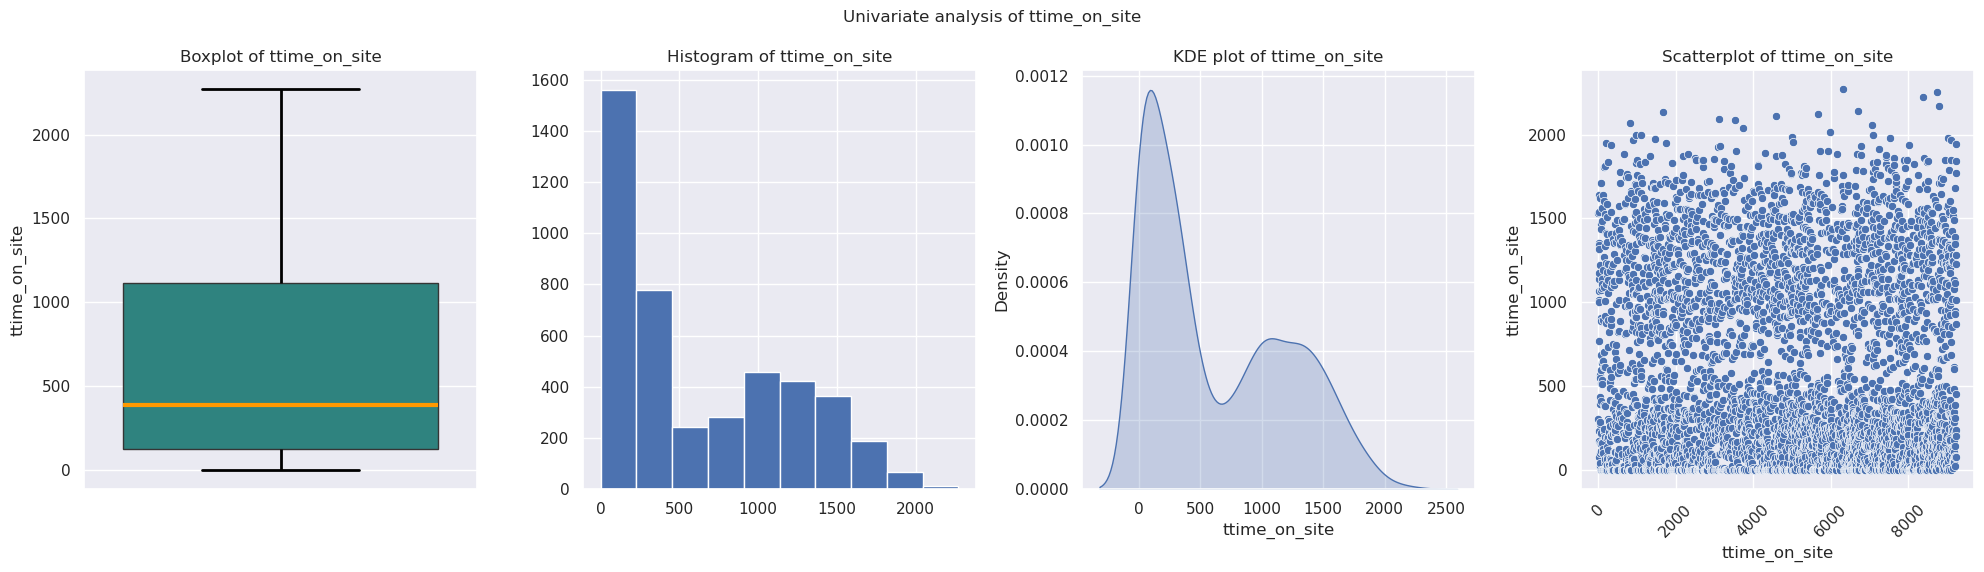

<Figure size 640x480 with 0 Axes>

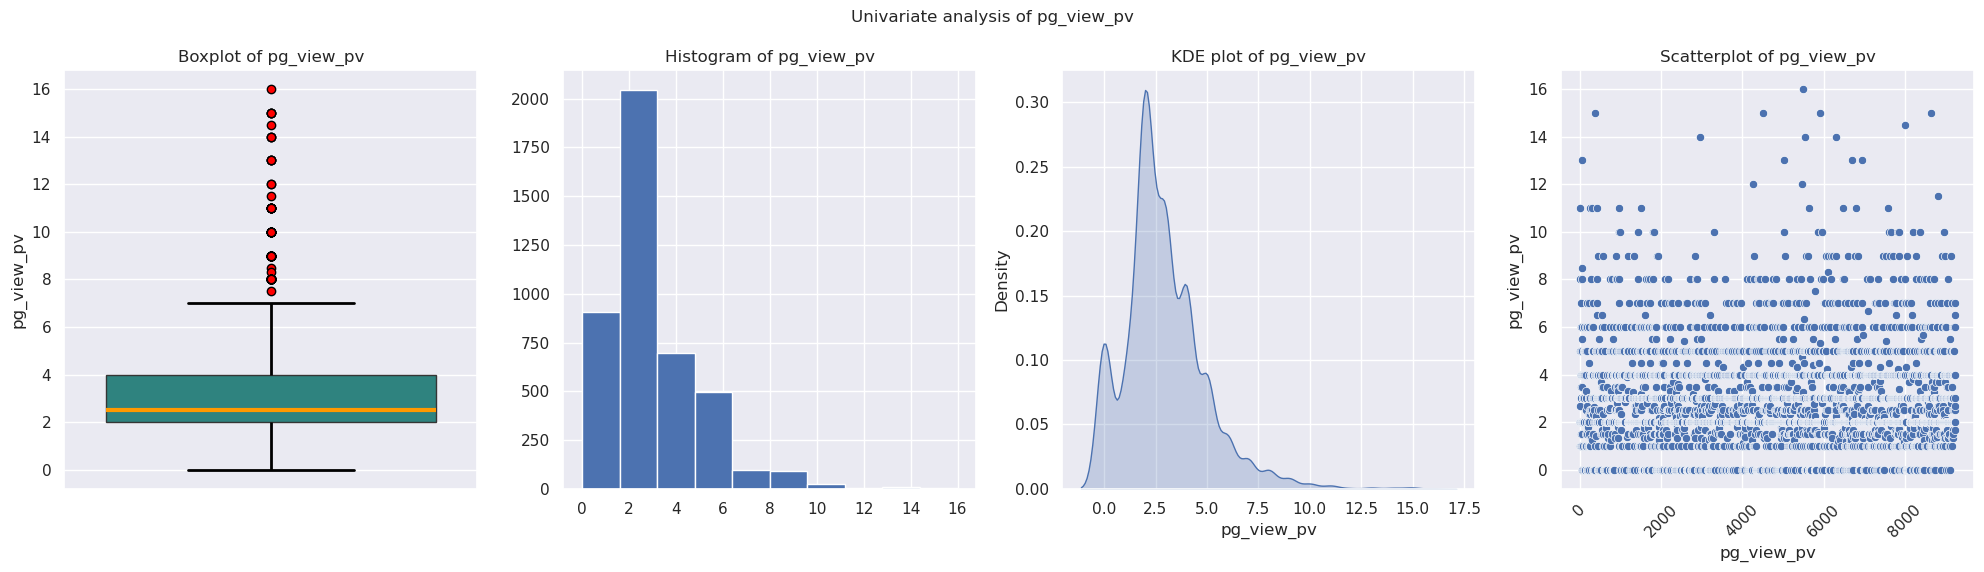

<Figure size 640x480 with 0 Axes>

In [148]:
univariate_plots(dff, dff.select_dtypes(include=[int,float]).columns, ftype='non_categorical')

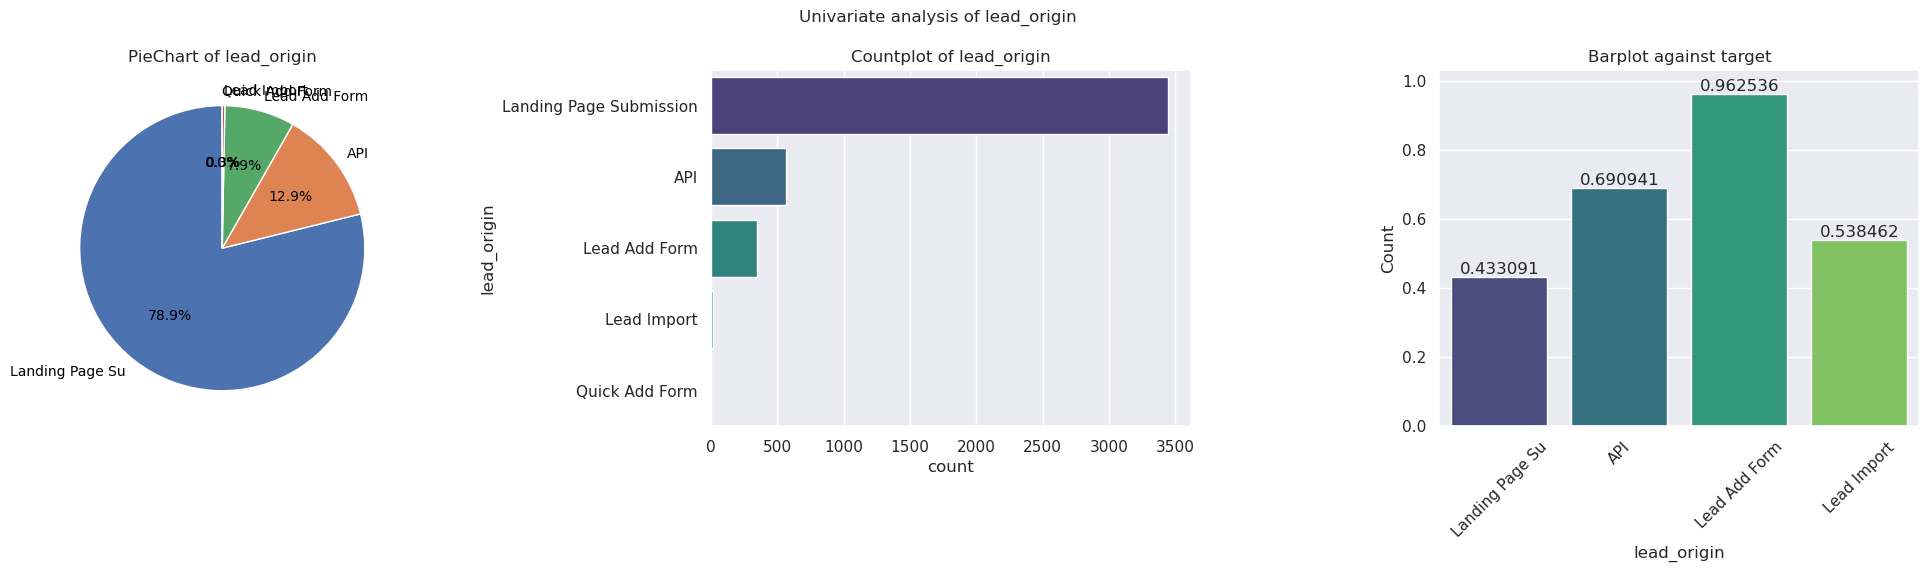

<Figure size 640x480 with 0 Axes>

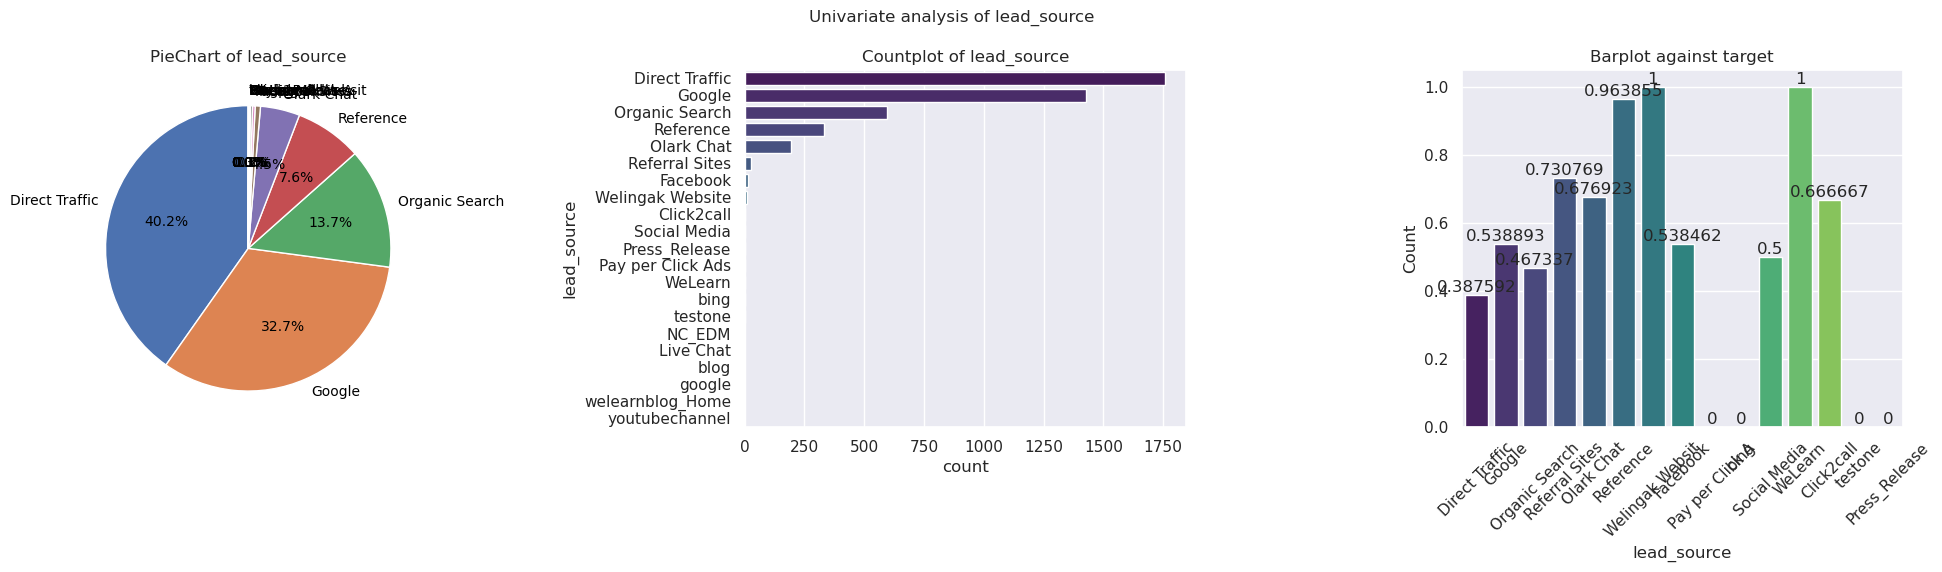

<Figure size 640x480 with 0 Axes>

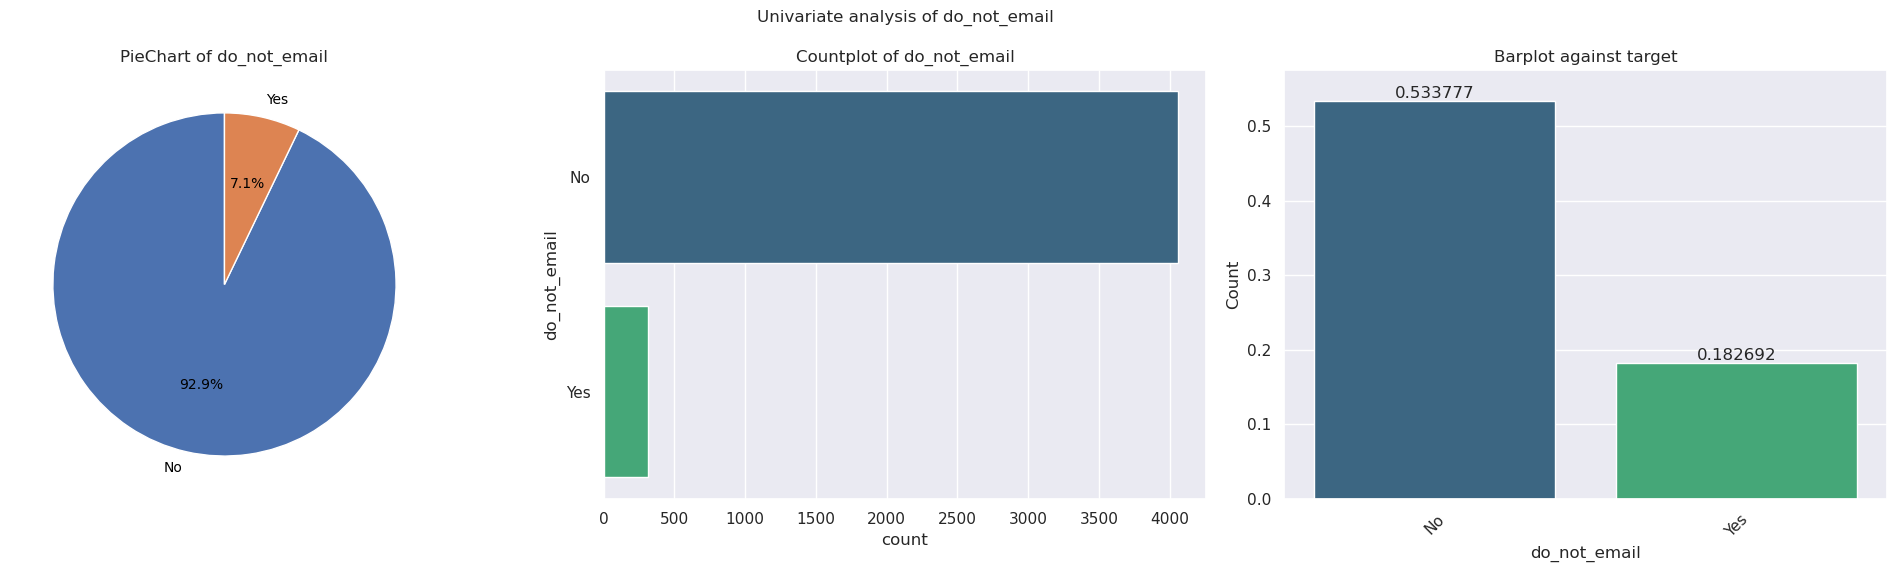

<Figure size 640x480 with 0 Axes>

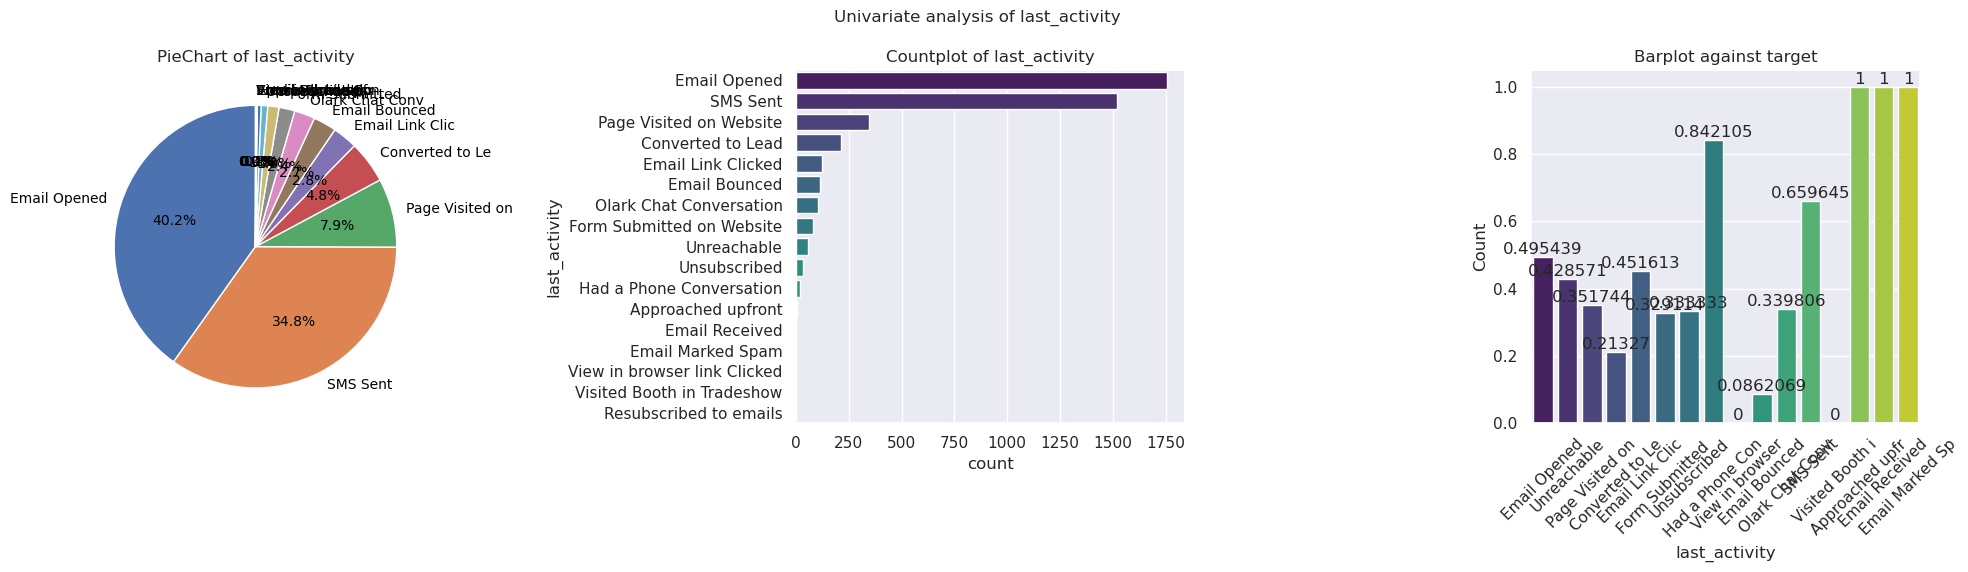

<Figure size 640x480 with 0 Axes>

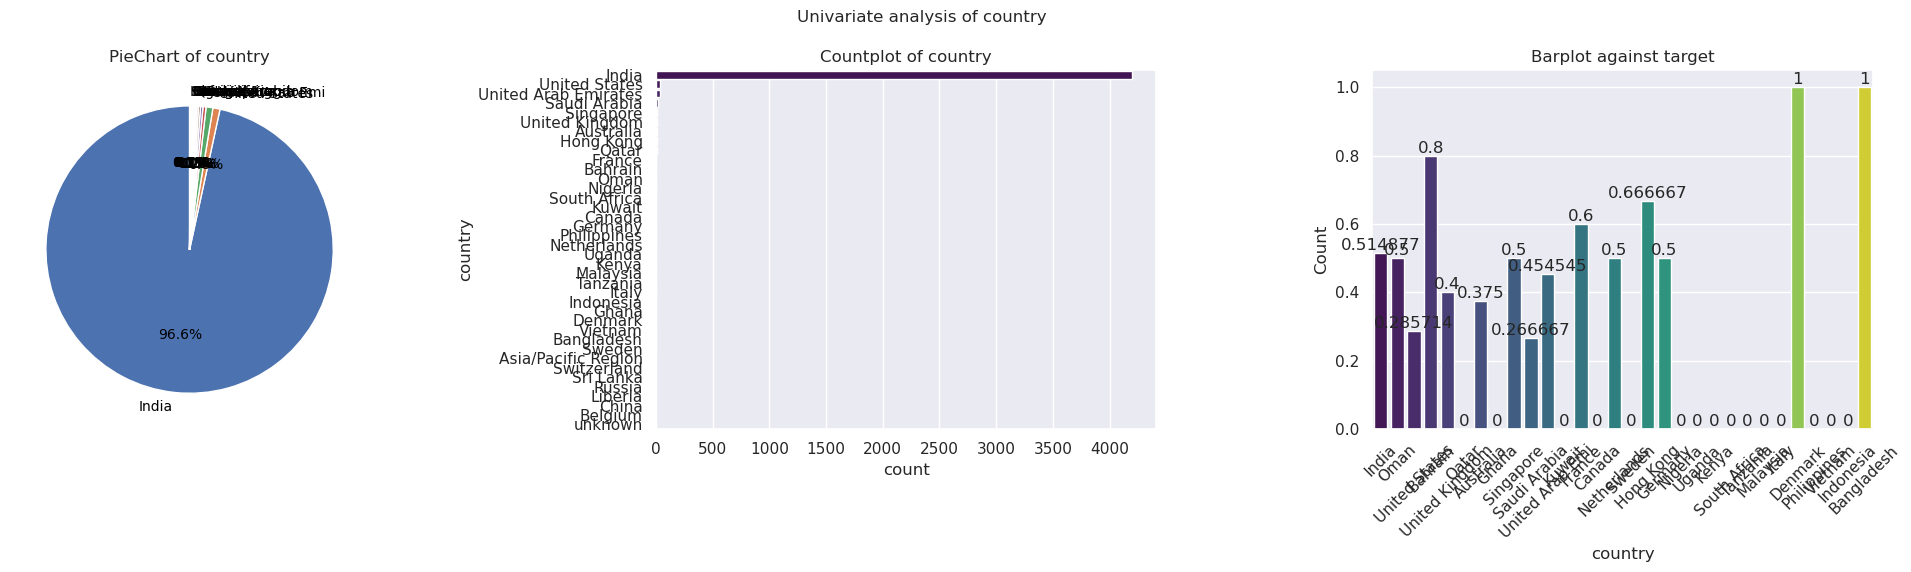

<Figure size 640x480 with 0 Axes>

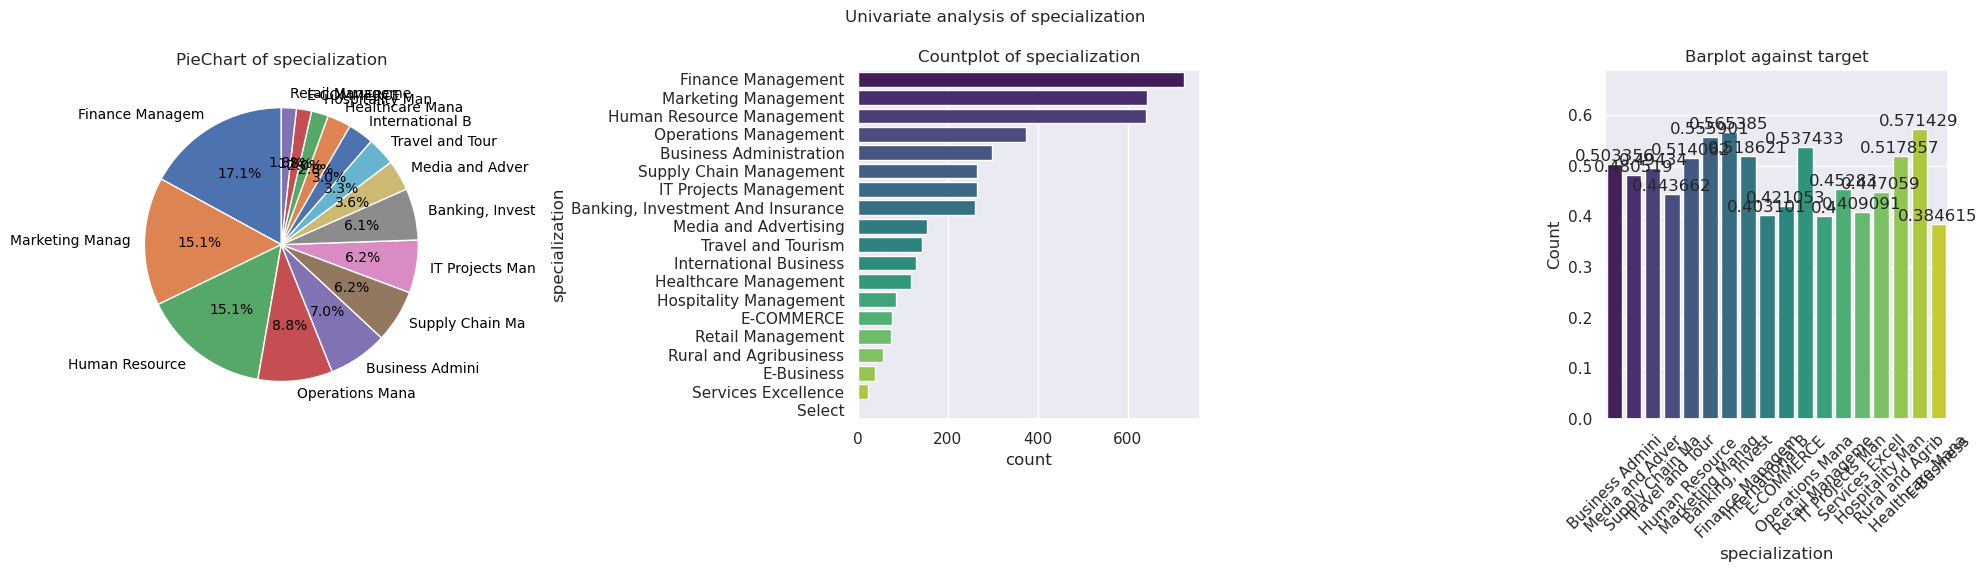

<Figure size 640x480 with 0 Axes>

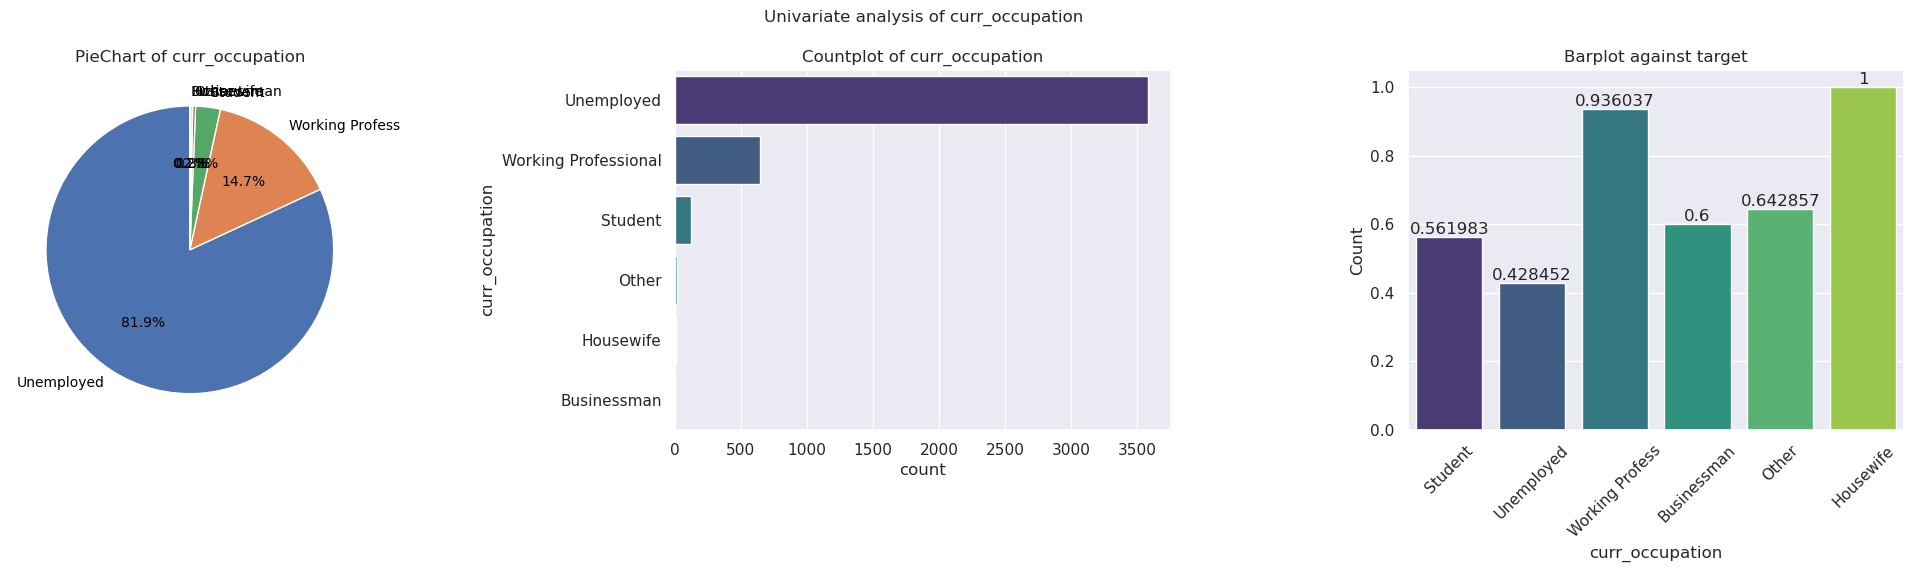

<Figure size 640x480 with 0 Axes>

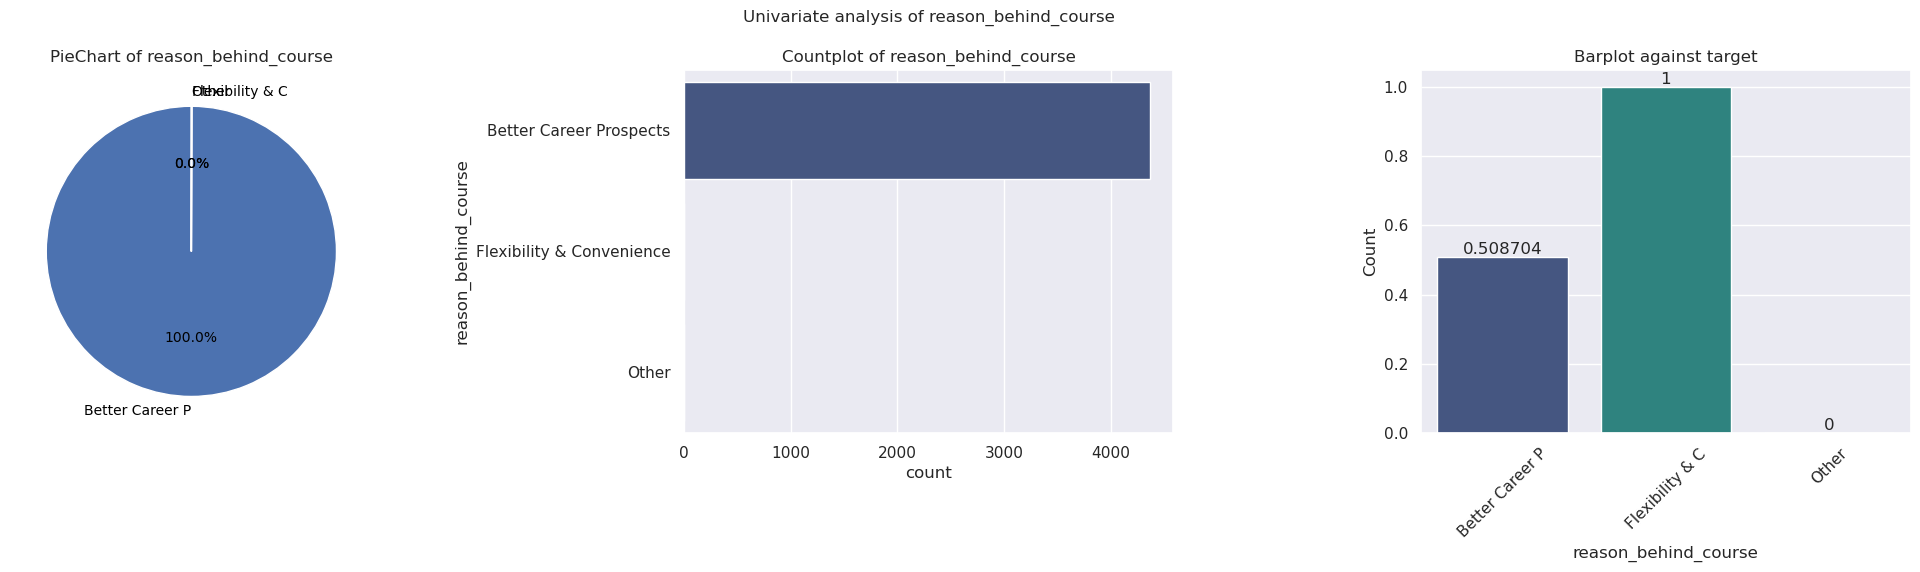

<Figure size 640x480 with 0 Axes>

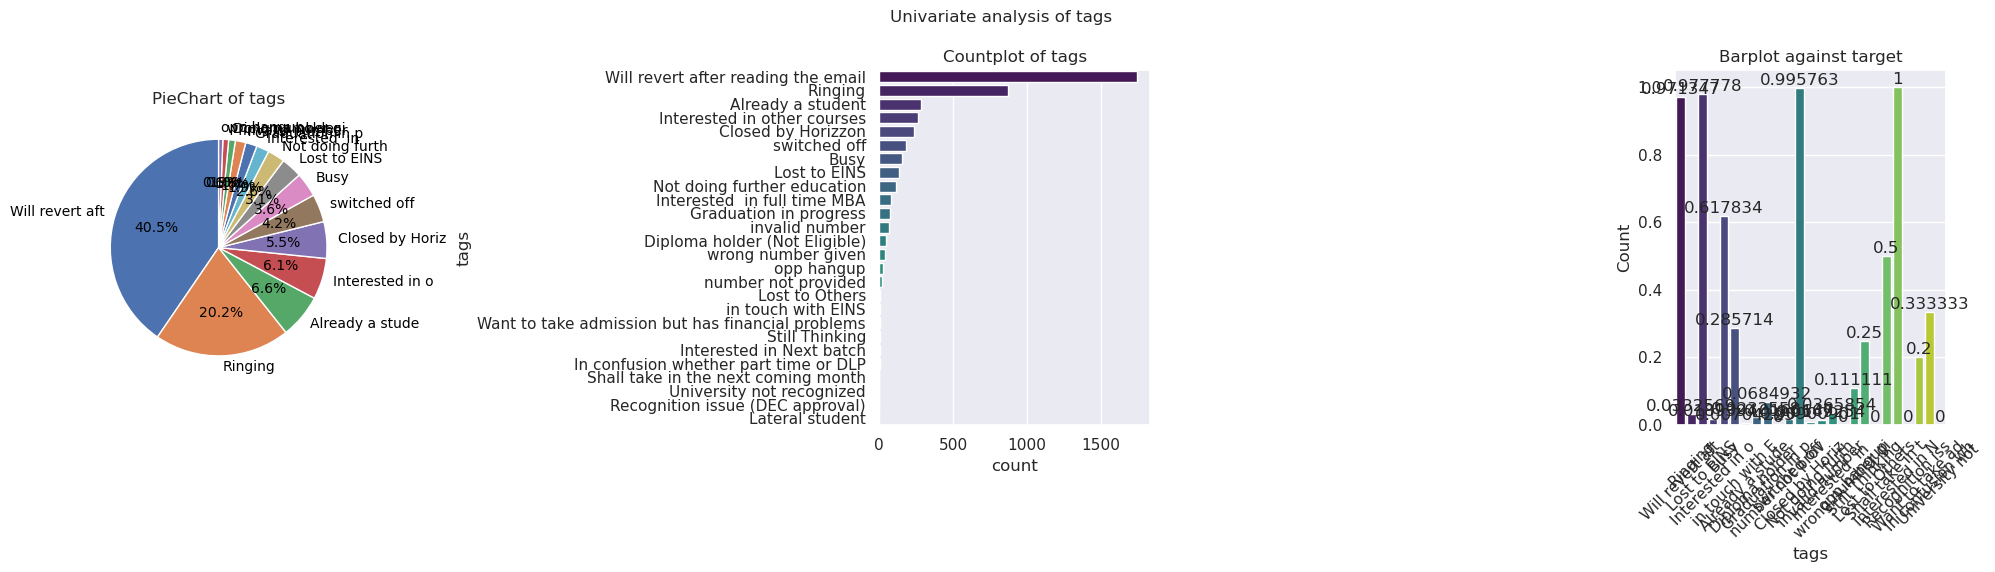

<Figure size 640x480 with 0 Axes>

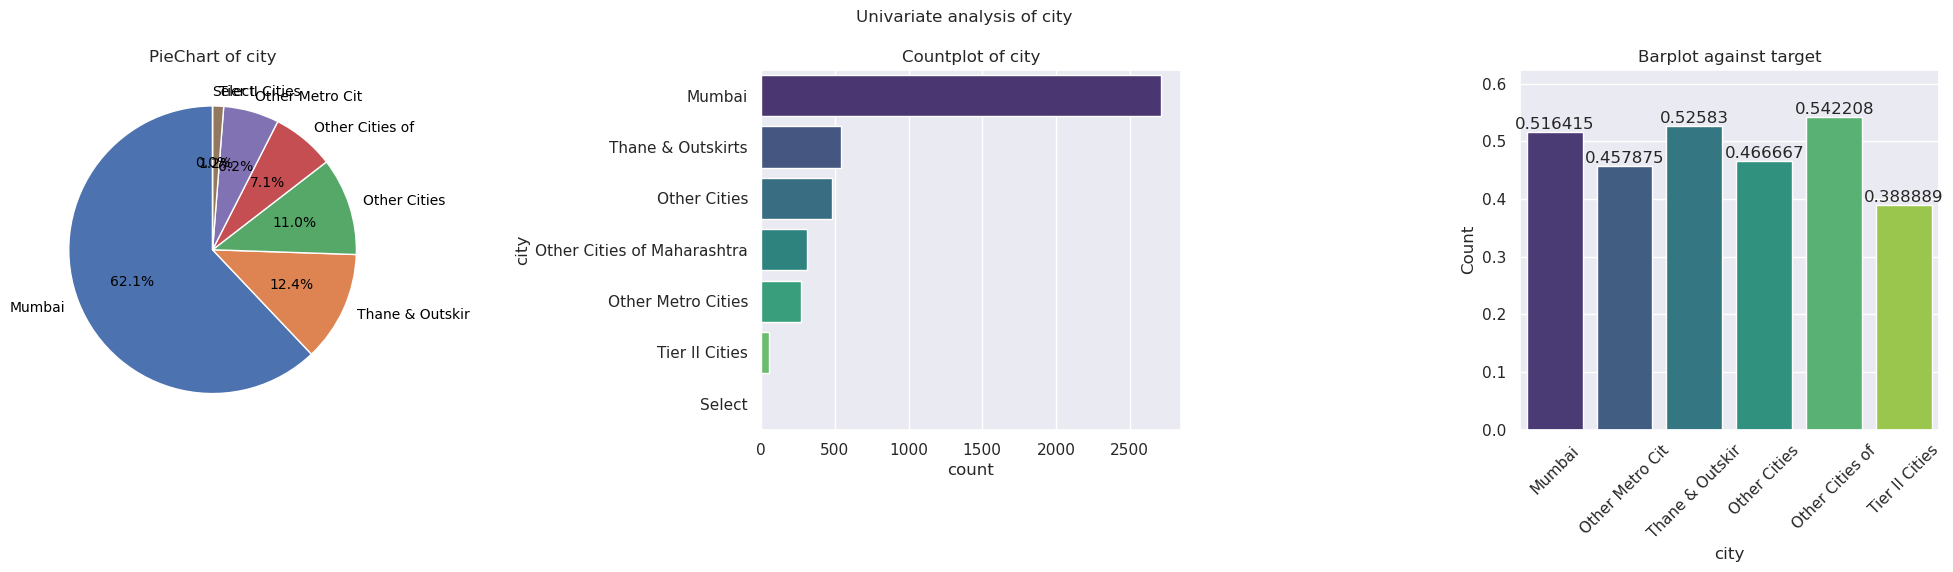

<Figure size 640x480 with 0 Axes>

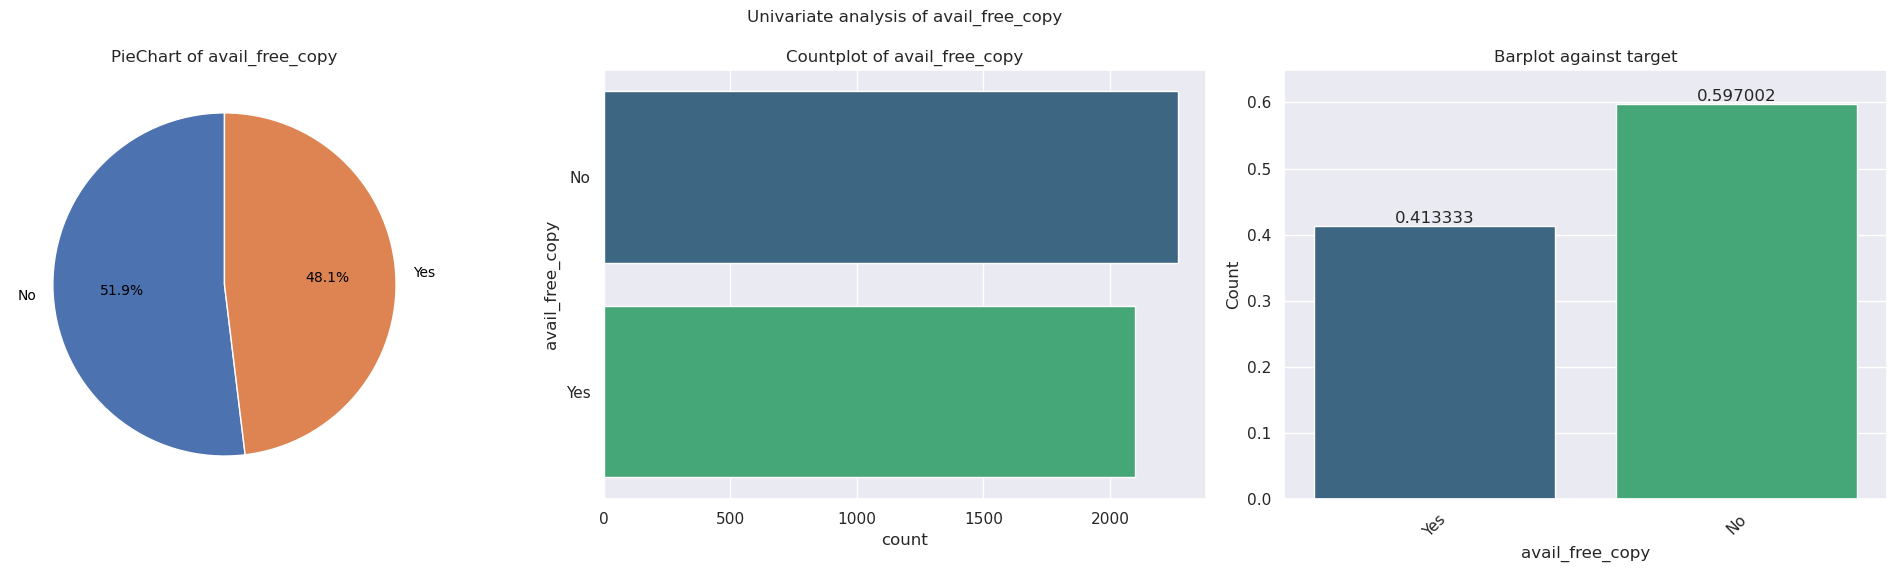

<Figure size 640x480 with 0 Axes>

In [149]:
univariate_plots(dff, dff.select_dtypes(exclude=[int,float]).columns, ftype='categorical',target='converted')

In [150]:
# plt.figure(figsize = (20,10))        # Size of the figure
# sns.heatmap(dff.select_dtypes(exclude='object').corr(),annot = True)
# plt.show()

In [151]:
dff.head(2)

lead_number              lead_origin     lead_source do_not_email  \
2   660727.000  Landing Page Submission  Direct Traffic           No   
3   660719.000  Landing Page Submission  Direct Traffic           No   

   converted  totalvisits  ttime_on_site  pg_view_pv last_activity country  \
2      1.000        2.000       1532.000       2.000  Email Opened   India   
3      0.000        1.000        305.000       1.000   Unreachable   India   

            specialization curr_occupation     reason_behind_course  \
2  Business Administration         Student  Better Career Prospects   
3    Media and Advertising      Unemployed  Better Career Prospects   

                                  tags    city avail_free_copy  
2  Will revert after reading the email  Mumbai             Yes  
3                              Ringing  Mumbai              No

In [152]:
cols = dff.select_dtypes(exclude=[int,float]).columns
cols = list(set(list(cols)) - set(['prospect_id']))
dff = pd.get_dummies(dff, columns=cols, drop_first=True, dtype=float)

In [153]:
dff.head(2)

lead_number  converted  totalvisits  ttime_on_site  pg_view_pv  \
2   660727.000      1.000        2.000       1532.000       2.000   
3   660719.000      0.000        1.000        305.000       1.000   

   reason_behind_course_Flexibility & Convenience  reason_behind_course_Other  \
2                                           0.000                       0.000   
3                                           0.000                       0.000   

   tags_Busy  tags_Closed by Horizzon  tags_Diploma holder (Not Eligible)  \
2      0.000                    0.000                               0.000   
3      0.000                    0.000                               0.000   

   tags_Graduation in progress  tags_In confusion whether part time or DLP  \
2                        0.000                                       0.000   
3                        0.000                                       0.000   

   tags_Interested  in full time MBA  tags_Interested in Next batch  \
2                              0.000                          0.000   
3                              0.000                          0.000   

   tags_Interested in other courses  tags_Lateral student  tags_Lost to EINS  \
2                             0.000                 0.000              0.000   
3                             0.000                 0.000              0.000   

   tags_Lost to Others  tags_Not doing further education  \
2                0.000                             0.000   
3                0.000                             0.000   

   tags_Recognition issue (DEC approval)  tags_Ringing  \
2                                  0.000         0.000   
3                                  0.000         1.000   

   tags_Shall take in the next coming month  tags_Still Thinking  \
2                                     0.000                0.000   
3                                     0.000                0.000   

   tags_University not recognized  \
2                           0.000   
3                           0.000   

   tags_Want to take admission but has financial problems  \
2                                              0.000        
3                                              0.000        

   tags_Will revert after reading the email  tags_in touch with EINS  \
2                                     1.000                    0.000   
3                                     0.000                    0.000   

   tags_invalid number  tags_number not provided  tags_opp hangup  \
2                0.000                     0.000            0.000   
3                0.000                     0.000            0.000   

   tags_switched off  tags_wrong number given  avail_free_copy_Yes  \
2              0.000                    0.000                1.000   
3              0.000                    0.000                0.000   

   specialization_Business Administration  specialization_E-Business  \
2                                   1.000                      0.000   
3                                   0.000                      0.000   

   specialization_E-COMMERCE  specialization_Finance Management  \
2                      0.000                              0.000   
3                      0.000                              0.000   

   specialization_Healthcare Management  \
2                                 0.000   
3                                 0.000   

   specialization_Hospitality Management  \
2                                  0.000   
3                                  0.000   

   specialization_Human Resource Management  \
2                                     0.000   
3                                     0.000   

   specialization_IT Projects Management  \
2                                  0.000   
3                                  0.000   

   specialization_International Business  specialization_Marketing Management  \
2                                  0.000                                0.000   
3                

In [154]:
import statsmodels.api as sm 
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import accuracy_score, recall_score,precision_score, roc_auc_score, confusion_matrix, f1_score, roc_curve, precision_recall_curve


In [155]:
X = dff.drop(['converted'],axis=1)
y = dff['converted']

In [156]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=100)

In [157]:
to_scale = ['lead_number', 'totalvisits', 'ttime_on_site', 'pg_view_pv']

scaler = StandardScaler()
X_train[to_scale] = scaler.fit_transform(X_train[to_scale],y_train)
X_train.head()

lead_number  totalvisits  ttime_on_site  pg_view_pv  \
1559        1.241       -0.402          0.360      -0.953   
5532       -0.333        0.145          0.571      -0.199   
6461       -0.640       -0.402          1.476      -0.450   
7316       -0.946       -0.219          0.914       0.053   
5706       -0.389       -0.219         -0.655      -0.702   

      reason_behind_course_Flexibility & Convenience  \
1559                                           0.000   
5532                                           0.000   
6461                                           0.000   
7316                                           0.000   
5706                                           0.000   

      reason_behind_course_Other  tags_Busy  tags_Closed by Horizzon  \
1559                       0.000      0.000                    1.000   
5532                       0.000      0.000                    0.000   
6461                       0.000      0.000                    0.000   
7316                       0.000      0.000                    0.000   
5706                       0.000      0.000                    0.000   

      tags_Diploma holder (Not Eligible)  tags_Graduation in progress  \
1559                               0.000                        0.000   
5532                               0.000                        0.000   
6461                               0.000                        0.000   
7316                               0.000                        0.000   
5706                               0.000                        0.000   

      tags_In confusion whether part time or DLP  \
1559                                       0.000   
5532                                       0.000   
6461                                       0.000   
7316                                       0.000   
5706                                       0.000   

      tags_Interested  in full time MBA  tags_Interested in Next batch  \
1559                              0.000                          0.000   
5532                              0.000                          0.000   
6461                              0.000                          0.000   
7316                              0.000                          0.000   
5706                              0.000                          0.000   

      tags_Interested in other courses  tags_Lateral student  \
1559                             0.000                 0.000   
5532                             0.000                 0.000   
6461                             0.000                 0.000   
7316                             0.000                 0.000   
5706                             0.000                 0.000   

      tags_Lost to EINS  tags_Lost to Others  \
1559              0.000                0.000   
5532              0.000                0.000   
6461              0.000                0.000   
7316              0.000                0.000   
5706              0.000                0.000   

      tags_Not doing further education  tags_Recognition issue (DEC approval)  \
1559                             0.000                                  0.000   
5532                             1.000                                  0.000   
6461                             0.000                                  0.000   
7316                             0.000                                  0.000   
5706                             0.000                                  0.000   

      tags_Ringing  tags_Shall take in the next coming month  \
1559         0.000                                     0.000   
5532         0.000                                     0.000   
6461         0.000                                     0.000   
7316         0.000                                     0.000   
5706         0.000                                     0.000   

      tags_Still Thinking  tags_University not recognized  \
1559                0.000                           0.000   
5532

<Figure size 2000x1000 with 0 Axes>

<Axes: >

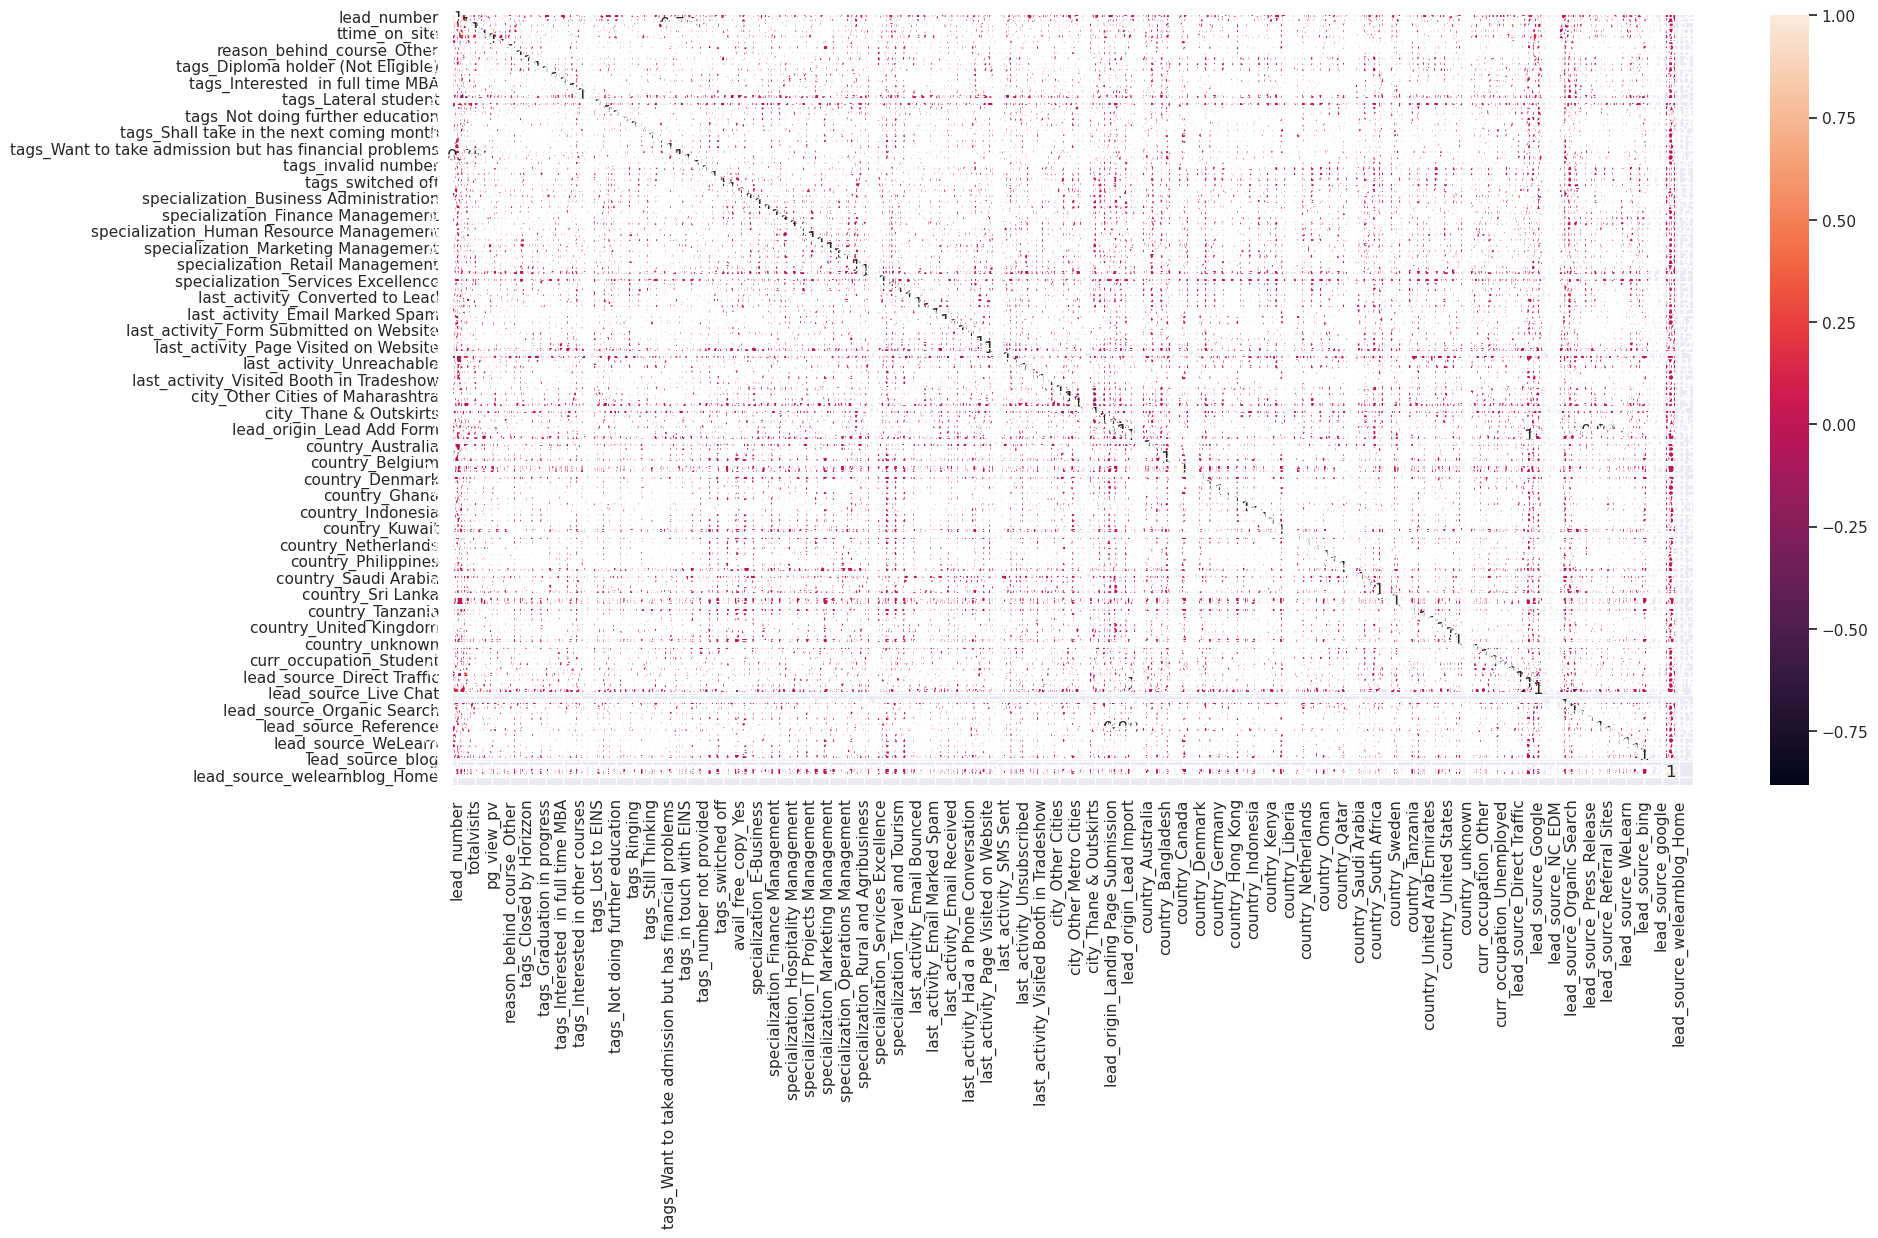

In [158]:
plt.figure(figsize = (20,10))        # Size of the figure
sns.heatmap(dff.select_dtypes(exclude='object').corr(),annot = True)
plt.show()

In [159]:
# Logistic regression model
logm1 = sm.GLM(y_train,(sm.add_constant(X_train)), family = sm.families.Binomial())
logm1.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              converted   No. Observations:                 3494
Model:                            GLM   Df Residuals:                     3378
Model Family:                Binomial   Df Model:                          115
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Thu, 10 Oct 2024   Deviance:                       21000.
Time:                        21:23:25   Pearson chi2:                 1.03e+18
No. Iterations:                   100   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
==========================================================================================================================
                                                             coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------
const                                                  -2.059e+15   9.56e+07  -2.15e+07      0.000   -2.06e+15   -2.06e+15
lead_number                                              7.34e+13   1.23e+06   5.98e+07      0.000    7.34e+13    7.34e+13
totalvisits                                             9.777e+13   1.26e+06   7.76e+07      0.000    9.78e+13    9.78e+13
ttime_on_site                                           1.883e+14   1.35e+06   1.39e+08      0.000    1.88e+14    1.88e+14
pg_view_pv                                              3.111e+12    1.5e+06   2.08e+06      0.000    3.11e+12    3.11e+12
reason_behind_course_Flexibility & Convenience              4e+15   6.77e+07   5.91e+07      0.000       4e+15       4e+15
reason_behind_course_Other                             -3.153e+15    6.8e+07  -4.64e+07      0.000   -3.15e+15   -3.15e+15
tags_Busy                                               7.773e+14   8.01e+06    9.7e+07      0.000    7.77e+14    7.77e+14
tags_Closed by Horizzon                                 9.525e+14   7.34e+06    1.3e+08      0.000    9.52e+14    9.52e+14
tags_Diploma holder (Not Eligible)                     -9.363e+13   1.31e+07  -7.16e+06      0.000   -9.36e+13   -9.36e+13
tags_Graduation in progress                            -7.929e+14   1.02e+07   -7.8e+07      0.000   -7.93e+14   -7.93e+14
tags_In confusion whether part time or DLP             -1.242e+15   3.93e+07  -3.16e+07      0.000   -1.24e+15   -1.24e+15
tags_Interested  in full time MBA                      -1.635e+14   9.72e+06  -1.68e+07      0.000   -1.63e+14   -1.63e+14
tags_Interested in Next batch                           4.411e+15   3.93e+07   1.12e+08      0.000    4.41e+15    4.41e+15
tags_Interested in other courses                        -2.84e+14   6.68e+06  -4.25e+07      0.000   -2.84e+14   -2.84e+14
tags_Lateral student                                      49.0456   1.34e-06   3.67e+07      0.000      49.046      49.046
tags_Lost to EINS                                       7.654e+14   8.09e+06   9.46e+07      0.000    7.65e+14    7.65e+14
tags_Lost to Others                                    -4.232e+15   3.08e+07  -1.38e+08      0.000   -4.23e+15   -4.23e+15
tags_Not doing further education                       -8.007e+13   8.69e+06  -9.21e+06      0.000   -8.01e+13   -8.01e+13
tags_Recognition issue (DEC approval)                  -4.431e+15   6.92e+07  -6.41e+07      0.000   -4.43e+15   -4.43e+15
tags_Ringing                                           -4.168e+13   5.58e+06  -7.47e+06      0.000   -4.17e+13   -4.17e+13
tags_Shall take in the next coming month                2.489e+14   4.79e+07   5.19e+06      0.000    2.49e+14    2.49e+14
tags_Sti

In [160]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()

In [161]:
from sklearn.feature_selection import RFE
rfe = RFE(estimator=logreg, n_features_to_select=15)             # running RFE with 13 variables as output
rfe = rfe.fit(X_train, y_train)

In [162]:
list(zip(X_train.columns, rfe.support_, rfe.ranking_))

[('lead_number', False, 35),
 ('totalvisits', False, 16),
 ('ttime_on_site', False, 5),
 ('pg_view_pv', False, 51),
 ('reason_behind_course_Flexibility & Convenience', False, 61),
 ('reason_behind_course_Other', False, 79),
 ('tags_Busy', True, 1),
 ('tags_Closed by Horizzon', True, 1),
 ('tags_Diploma holder (Not Eligible)', False, 9),
 ('tags_Graduation in progress', False, 58),
 ('tags_In confusion whether part time or DLP', False, 32),
 ('tags_Interested  in full time MBA', False, 6),
 ('tags_Interested in Next batch', True, 1),
 ('tags_Interested in other courses', True, 1),
 ('tags_Lateral student', False, 108),
 ('tags_Lost to EINS', True, 1),
 ('tags_Lost to Others', False, 14),
 ('tags_Not doing further education', True, 1),
 ('tags_Recognition issue (DEC approval)', False, 72),
 ('tags_Ringing', True, 1),
 ('tags_Shall take in the next coming month', False, 8),
 ('tags_Still Thinking', False, 97),
 ('tags_University not recognized', False, 119),
 ('tags_Want to take admission

In [163]:
col = X_train.columns[rfe.support_]
X_train.columns[~rfe.support_]

Index(['lead_number', 'totalvisits', 'ttime_on_site', 'pg_view_pv',
       'reason_behind_course_Flexibility & Convenience',
       'reason_behind_course_Other', 'tags_Diploma holder (Not Eligible)',
       'tags_Graduation in progress',
       'tags_In confusion whether part time or DLP',
       'tags_Interested  in full time MBA',
       ...
       'lead_source_Referral Sites', 'lead_source_Social Media',
       'lead_source_WeLearn', 'lead_source_Welingak Website',
       'lead_source_bing', 'lead_source_blog', 'lead_source_google',
       'lead_source_testone', 'lead_source_welearnblog_Home',
       'lead_source_youtubechannel'],
      dtype='object', length=124)

In [164]:
X_train_sm = sm.add_constant(X_train[col])
logm2 = sm.GLM(y_train, X_train_sm, family = sm.families.Binomial())
res = logm2.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              converted   No. Observations:                 3494
Model:                            GLM   Df Residuals:                     3478
Model Family:                Binomial   Df Model:                           15
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -477.84
Date:                Thu, 10 Oct 2024   Deviance:                       955.68
Time:                        21:23:34   Pearson chi2:                 3.44e+03
No. Iterations:                    22   Pseudo R-squ. (CS):             0.6713
Covariance Type:            nonrobust                                         
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                       -3.4981      0.260    -13.445      0.000      -4.008      -2.988
tags_Busy                                    3.3370      0.323     10.322      0.000       2.703       3.971
tags_Closed by Horizzon                      8.5188      1.036      8.223      0.000       6.488      10.549
tags_Interested in Next batch               25.9750   4.59e+04      0.001      1.000   -8.99e+04    8.99e+04
tags_Interested in other courses            -0.7023      0.567     -1.238      0.216      -1.814       0.410
tags_Lost to EINS                            6.9419      0.640     10.845      0.000       5.687       8.197
tags_Not doing further education            -1.1492      1.038     -1.107      0.268      -3.184       0.886
tags_Ringing                                -0.5159      0.345     -1.494      0.135      -1.193       0.161
tags_Will revert after reading the email     6.3840      0.301     21.206      0.000       5.794       6.974
tags_in touch with EINS                      2.4012      0.890      2.699      0.007       0.657       4.145
tags_invalid number                         -0.9240      1.047     -0.882      0.378      -2.976       1.128
tags_switched off                           -1.0865      0.662     -1.641      0.101      -2.384       0.211
tags_wrong number given                    -20.7940   1.36e+04     -0.002      0.999   -2.67e+04    2.67e+04
last_activity_SMS Sent                       1.0892      0.207      5.263      0.000       0.684       1.495
country_Germany                              4.0413      1.507      2.682      0.007       1.087       6.995
curr_occupation_Working Professional         1.0744      0.409      2.629      0.009       0.273       1.875
============================================================================================================
"""

In [165]:
y_train_pred = res.predict(X_train_sm)
y_train_pred[:10]

1559   0.998
5532   0.009
6461   0.982
7316   0.947
5706   0.994
3103   0.717
7218   0.051
824    0.981
4441   0.029
2935   0.717
dtype: float64

In [166]:
y_train_pred = y_train_pred.values.reshape(-1)
y_train_pred[:10]

array([0.99775122, 0.00949704, 0.98156909, 0.94714716, 0.99362835,
       0.7166938 , 0.05094162, 0.98129945, 0.02936713, 0.7166938 ])

In [167]:
y_train_pred_final = pd.DataFrame({'Churn':y_train.values, 'Churn_Prob':y_train_pred})
y_train_pred_final['CustID'] = y_train.index
y_train_pred_final.head()

Churn  Churn_Prob  CustID
0  1.000       0.998    1559
1  0.000       0.009    5532
2  1.000       0.982    6461
3  1.000       0.947    7316
4  1.000       0.994    5706

In [168]:
y_train_pred_final['predicted'] = y_train_pred_final.Churn_Prob.map(lambda x: 1 if x > 0.5 else 0)

# Let's see the head
y_train_pred_final.head()

Churn  Churn_Prob  CustID  predicted
0  1.000       0.998    1559          1
1  0.000       0.009    5532          0
2  1.000       0.982    6461          1
3  1.000       0.947    7316          1
4  1.000       0.994    5706          1

In [169]:
# Confusion matrix 
confusion = confusion_matrix(y_train_pred_final.Churn, y_train_pred_final.predicted )
print(confusion)

[[1656   73]
 [  78 1687]]


In [170]:
print(accuracy_score(y_train_pred_final.Churn, y_train_pred_final.predicted))

0.9567830566685747


In [171]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[col].columns
vif['VIF'] = [variance_inflation_factor(X_train[col].values, i) for i in range(X_train[col].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

Features   VIF
12                    last_activity_SMS Sent 1.800
7   tags_Will revert after reading the email 1.790
14      curr_occupation_Working Professional 1.410
6                               tags_Ringing 1.140
0                                  tags_Busy 1.070
1                    tags_Closed by Horizzon 1.040
10                         tags_switched off 1.040
11                   tags_wrong number given 1.020
4                          tags_Lost to EINS 1.010
9                        tags_invalid number 1.010
2              tags_Interested in Next batch 1.000
3           tags_Interested in other courses 1.000
5           tags_Not doing further education 1.000
8                    tags_in touch with EINS 1.000
13                           country_Germany 1.000

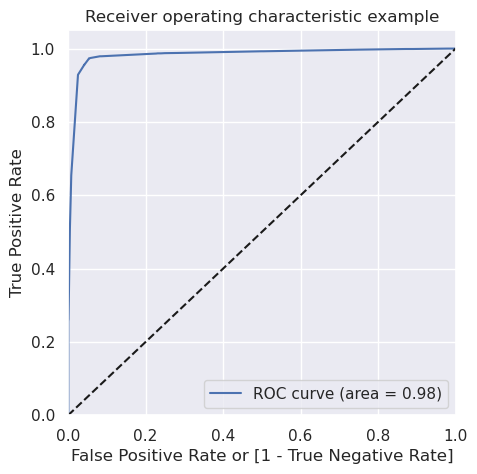

In [172]:
def draw_roc( actual, probs ):
    fpr, tpr, thresholds = roc_curve( actual, probs, drop_intermediate = False )
    auc_score = roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()
    return None

fpr, tpr, thresholds = roc_curve( y_train_pred_final.Churn, y_train_pred_final.Churn_Prob, drop_intermediate = False )
draw_roc(y_train_pred_final.Churn, y_train_pred_final.Churn_Prob)

In [173]:
precision_score(y_train_pred_final.Churn, y_train_pred_final.predicted)
recall_score(y_train_pred_final.Churn, y_train_pred_final.predicted)

0.9585227272727272

0.9558073654390935

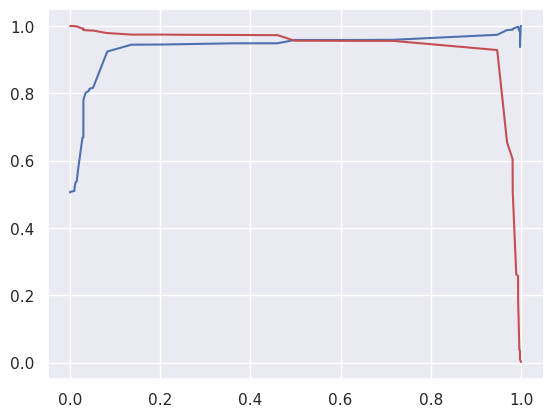

In [174]:
p, r, thresholds = precision_recall_curve(y_train_pred_final.Churn, y_train_pred_final.Churn_Prob)
plt.plot(thresholds, p[:-1], "b-")
plt.plot(thresholds, r[:-1], "r-")
plt.show()